Adam Pfiser  |  102120  |  Honorlock Support and Proctor Data Exploration (091320-091820)

## CONTENTS  
1. __Explore Initial Dataset Before Cleaning__  
    A. Import libraries  
    B. Import dataset  
    C. Sample view    
    D. Basic info, size and shape  
    E. Basic statistics  
    F. Missing data  
    G. Change column names  
    H. Print averages (mean) of key numerical data  
    I. Distributions of key numerical data  
    J. Countplot of total chats per day (support plus proctor)  
    K. Countplot of total rated chats (support plus proctor)  
    L. Countplot of total visits per visitor ip group  


2. __Data Cleaning__  
    A. Drop unnecessary columns  
    B. Drop outliers  
    C. Fill missing talk time data (total chat time - wait time)  
    D. Fill missing first response data (mean of column)  
    E. Drop remaining insignificant data  
    F. Round and drop decimals from dataframe  
    G. Convert chate date column to pd.datetime  
    H. Create variables  
        - day_name = name of day of week  
        - day_week = day number of week (0-6, 0=sunday)  
        - day_month = day number of month (1-31)  

3. __Data Exploration After Cleaning__  
    A. Create support-only dataframe  
    B. Basic info, size and shape  
    C. Print support-only averages (mean) of key numerical data  
    D. Create proctor-only dataframe    
    E. Basic info, size and shape  
    F. Print proctor-only averages (mean) of key numerical data  
    G. Boxplots of support-only key numerical data  
    H. Boxplots of proctor-only key numerical data  
    I. Distributions of support-only key numerical data  
    J. Distributions of proctor-only key numerical data  
    K. Countplot of total chats per day (support-only)  
    L. Countplot of total chats per day (procto-only)  
    M. Correlation heatmap of support-only key numerical data  
    N. Correlation heatmap of proctor-only key numerical data  


4. __Summary Report__

## 1. EXPLORE INITIAL DATASET BEFORE CLEANING

In [ ]:
# 1A
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline

In [2]:
# 1B
# import dataset
df = pd.read_csv(r'C:\Users\AP\Desktop\Support_stats - 20200913_20200918.csv')

# change all columns to lower case
df.columns = map(str.lower, df.columns)

In [3]:
# 1C
# sample view
df.head()

,chat creation date america/new_york,chat duration in seconds,queue duration in seconds,visitor nick,visitor ip,group name,rate,first response time,average response time,agents chatting duration
0,2020-09-13 0:00:09,479,15.0,Curtis Johnson,Chat,Student,not rated,141.0,141.0,464.0
1,2020-09-13 0:00:55,248,3.0,Proctoring: James Fowlkes,Pop-In,Student,not rated,7.0,7.0,246.0
2,2020-09-13 0:01:18,228,7.0,Taidan Johnson,Chat,Student,rated bad,5.0,55.0,221.0
3,2020-09-13 0:01:20,1713,7.0,Jake Lasseter,Chat,Student,not rated,111.0,111.0,1706.0
4,2020-09-13 0:02:51,398,48.0,Timothy Brehm,Chat,Student,not rated,NaN,NaN,350.0


In [4]:
# 1D
# basic size and shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39026 entries, 0 to 39025
Data columns (total 10 columns):
chat creation date america/new_york    39026 non-null object
chat duration in seconds               39026 non-null int64
queue duration in seconds              38950 non-null float64
visitor nick                           39026 non-null object
visitor ip                             39026 non-null object
group name                             39026 non-null object
rate                                   39026 non-null object
first response time                    26963 non-null float64
average response time                  26963 non-null float64
agents chatting duration               10781 non-null float64
dtypes: float64(4), int64(1), object(5)
memory usage: 2.2+ MB


#### Observations  
- 10 columns, 39k rows  
- Good mix of categorical and numerical data

In [5]:
# 1E
# basic statistics of numerical data
df.describe().round().astype(int)

,chat duration in seconds,queue duration in seconds,first response time,average response time,agents chatting duration
count,39026,38950,26963,26963,10781
mean,587,136,63,64,2006
std,578,155,65,55,114906
min,2,1,0,0,0
25%,202,28,21,28,104
50%,434,93,43,50,298
75%,793,188,83,84,650
max,8120,2517,862,750,11671953


#### Observations  
- Significant outliers which will skew the data. Recommended to have reasonable cutoff times.

In [6]:
# 1F
# display missing data count and percent
print('Missing Data (count and percent)')
total_missing = df.isnull().sum().sort_values(ascending=False)
percent_missing = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

Missing Data (count and percent)


,Total,Percent
agents chatting duration,28245,0.723748
average response time,12063,0.309102
first response time,12063,0.309102
queue duration in seconds,76,0.001947
rate,0,0.000000
group name,0,0.000000
visitor ip,0,0.000000
visitor nick,0,0.000000
chat duration in seconds,0,0.000000
chat creation date america/new_york,0,0.000000


#### Observations  
- Significant missing data in:  
    - Agents chatting duration: 72%  
    - First response time: 31%  
    
    
- Can reverse-compute and fill missing 'agents chatting duration' data by subtracting 'queue duration' from 'chat duration'.  
- Recommended to fill missing 'first response time' with average (mean) of column and drop remaining nulls.

In [7]:
# 1G
# change column names
df.columns = ['chat_date', 
              'chat_total', 
              'wait_time', 
              'visitor_nick', 
              'visitor_ip', 
              'group',
              'rated',
              'first_resp',
              'avg_resp',
              'talk_time'
             ]

In [8]:
# 1H
# print column averages (mean)
print('Column averages (mean) before data cleaning (mins)')
print('')
print('Total chat time: ', (df.chat_total.mean()/60).round(1))
print('Talk time:       ', (df.talk_time.mean()/60).round(1))
print('Wait time:       ', (df.wait_time.mean()/60).round(1))
print('First response:  ', (df.first_resp.mean()/60).round(1))

Column averages (mean) before data cleaning (mins)

Total chat time:  9.8
Talk time:        33.4
Wait time:        2.3
First response:   1.1


Combined Support/Pop-in Chat Distributions (secs)


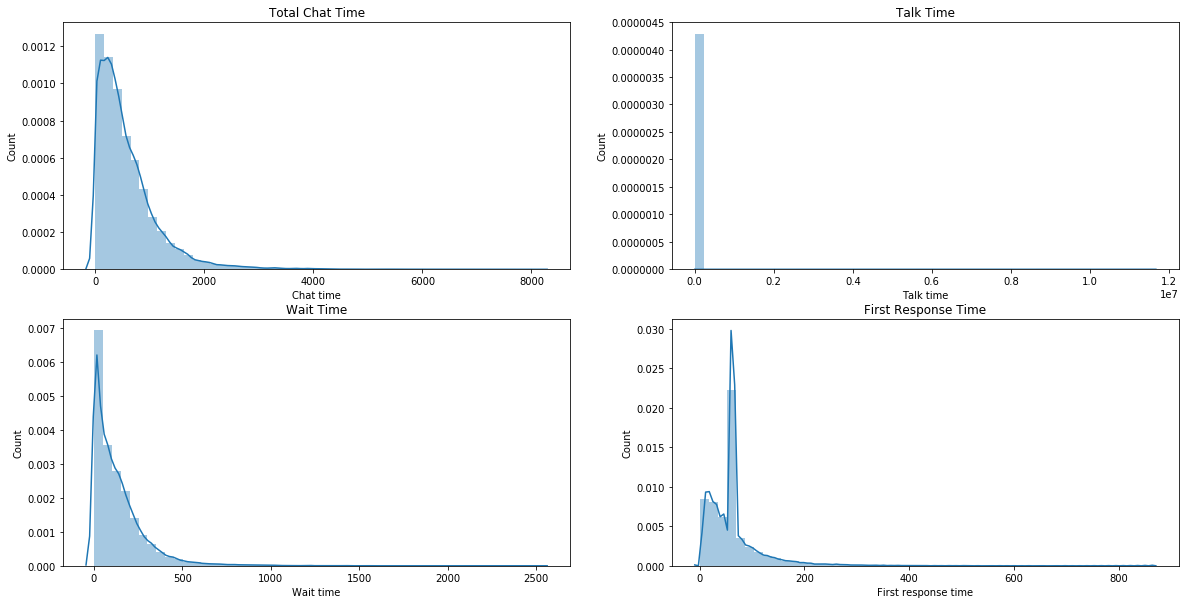

In [16]:
# 1I
# support chat distribution plots before data cleaning
print('Combined Support/Pop-in Chat Distributions (secs)')

plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
sns.distplot(df.chat_total)
plt.title('Total Chat Time')
plt.xlabel('Chat time')
plt.ylabel('Count')

plt.subplot(2,2,2)
sns.distplot(df.talk_time)
plt.title('Talk Time')
plt.xlabel('Talk time')
plt.ylabel('Count')

plt.subplot(2,2,3)
sns.distplot(df.wait_time)
plt.title('Wait Time')
plt.xlabel('Wait time')
plt.ylabel('Count')

plt.subplot(2,2,4)
sns.distplot(df.first_resp)
plt.title('First Response Time')
plt.xlabel('First response time')
plt.ylabel('Count')

plt.show()

#### Observations  
- All four heavily skewed right.  
    - 'Total chat time' trails off after ~2000 secs (33 mins)  
    - 'Talk time' is too skewed to many any sense of.  
    - 'Wait time' trails off after ~500 secs (8 mins)  
    - 'First response time' spikes around ~75 secs (1.25 mins) and abruptly trails off.  
    
    
- As indicated above, significant outliers are present and should be dropped to get a better picture of the meaningful data.

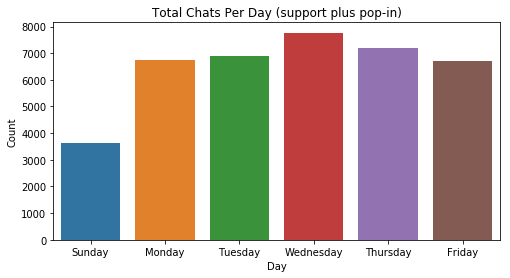

Total Chat count:  38950
Total Chats per day:

Wednesday    7767
Thursday     7194
Tuesday      6896
Monday       6734
Friday       6722
Sunday       3637
Name: day_name, dtype: int64


In [17]:
# 1J
# countplot of total chats per day (support plus pop-in)
plt.figure(figsize=(8,4))

sns.countplot(x=df.day_name)
             
plt.title('Total Chats Per Day (support plus pop-in)')
plt.xlabel('Day')
plt.ylabel('Count')

plt.show()

# print total chat count
print('Total Chat count: ', df.day_name.count() )

# print totals
print('Total Chats per day:')
print('')
print(df.day_name.value_counts())

#### Observations  
- Chat volume peaked on Wednesday, but Monday-Friday are not significantly slower.  
- Compared to Wednesday, Friday (slowest weekday) is 13% slower by volume.  
- Compared to Wednesday, Sunday (slowest day in data) is 53% slower by volume.

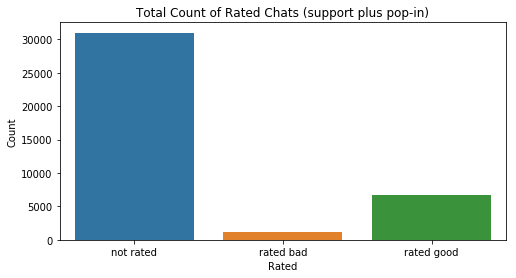

Total Chat count:  38950

Total Rated chats:

not rated     30975
rated good     6756
rated bad      1219
Name: rated, dtype: int64


In [18]:
# 1K
# countplot of rated chats
plt.figure(figsize=(8,4))

sns.countplot(x=df.rated)
             
plt.title('Total Rated Chats (support plus pop-in)')
plt.xlabel('Rated')
plt.ylabel('Count')

plt.show()

# print total chat count
print('Total Chat count: ', df.rated.count())

print('')

# print totals
print('Total Rated chats:')
print('')
print(df.rated.value_counts())

#### Observations  
- Out of 30,975 total chats, 7975 were rated (25.8%)  
- Rated good: 21.8%  
- Rated bad: 3.9%

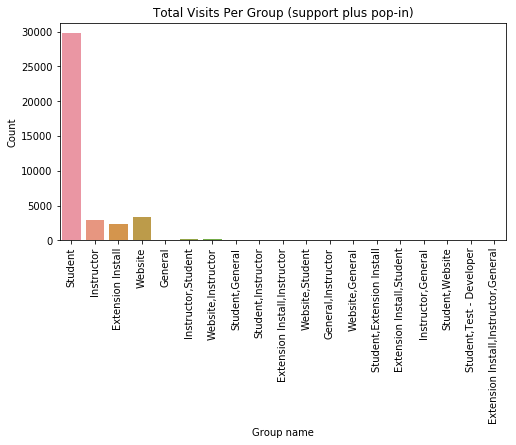

Total chat count:  38950

Total visits per group:

Student                                 29768
Website                                  3376
Instructor                               2967
Extension Install                        2329
Instructor,Student                        184
Website,Instructor                        155
General                                    55
Student,Instructor                         46
Extension Install,Instructor               17
General,Instructor                         16
Website,Student                            15
Extension Install,Student                  10
Student,General                             4
Student,Extension Install                   3
Instructor,General                          1
Extension Install,Instructor,General        1
Student,Website                             1
Student,Test - Developer                    1
Website,General                             1
Name: group, dtype: int64


In [19]:
# 1L
# countplot of visitor groups
plt.figure(figsize=(8,4))

g = sns.countplot(x=df.group)
             
plt.title('Total Visits Per Group (support plus pop-in)')
plt.xlabel('Group name')
plt.xticks(rotation=90)
plt.ylabel('Count')

plt.show()

# print total chat count
print('Total chat count: ', df.group.count())

print('')

# print totals
print('Total visits per group:')
print('')
print(df.group.value_counts())

#### Observations  
- Significant groups include:  
    - Student: 76.4%  
    - Website: 8.7%  
    - Instructor: 7.6%
    - Extension hall: 6%  
    - Total chats from these four groups: 98.7%  
    
    
- Many of these groups can be combined as differences only appear in name, but the combination would negligible, as 98.7% of visitors are already accounted for with the above four groups.

## 2. DATA CLEANING

In [9]:
# 2A
# drop unnecessary columns
df = df.drop('visitor_nick', 1)
df = df.drop('avg_resp', 1)

In [20]:
# 2B
# drop outliers
# limits recommended by Matt

# total chat time including wait and talk time (<= 60 mins)
df = df[df.chat_total < 3600]

# wait time (<= 20 mins)
df = df[df.wait_time < 1200]

# first response time (<= 10 mins)
df = df[df.first_resp < 600]

# talk time (<= 60 mins)
df = df[df.talk_time < 3600]

In [10]:
# 2C
# reverse compute and fill missing talk time data (total chat time - wait time = talk time)
df.talk_time.fillna((df.chat_total - df.wait_time), inplace=True)

In [11]:
# 2D
# fill missing first response data with average (mean)
df.first_resp.fillna(df.first_resp.mean(), inplace=True)

In [12]:
# 2E
# drop remaining missing data (insignificant)
df.dropna(inplace=True)

In [13]:
# 2F
# drop decimals from numerical values
df['chat_total'] = df.chat_total.round().astype(int)
df['wait_time'] = df.wait_time.round().astype(int)
df['first_resp'] = df.first_resp.round().astype(int)
df['talk_time'] = df.talk_time.round().astype(int)

In [14]:
# 2G
# convert chat date column to datetime
df['chat_date'] = pd.to_datetime(df.chat_date)

In [15]:
# 2H
# create variables

# weekday name
df['day_name'] = df.chat_date.dt.weekday_name

# day number of week (1-31)
df['day_week'] = df.chat_date.dt.dayofweek

# day number of month (0-6, sunday=0)
df['day_month'] = df.chat_date.dt.day

## 3. DATA EXPLORATION AFTER CLEANING

In [21]:
# 3A
# create chat-only dataframe
df_chat = df.loc[df.visitor_ip == 'Chat']

In [22]:
# 3B
# basic size and shape
df_chat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35819 entries, 0 to 39025
Data columns (total 11 columns):
chat_date     35819 non-null datetime64[ns]
chat_total    35819 non-null int32
wait_time     35819 non-null int32
visitor_ip    35819 non-null object
group         35819 non-null object
rated         35819 non-null object
first_resp    35819 non-null int32
talk_time     35819 non-null int32
day_name      35819 non-null object
day_week      35819 non-null int64
day_month     35819 non-null int64
dtypes: datetime64[ns](1), int32(4), int64(2), object(4)
memory usage: 2.2+ MB


In [23]:
# 3C
# print column averages (mean)
print('Column averages (mean) after data cleaning (mins)')
print('')
print('Total chat time:      ', (df_chat.chat_total.mean()/60).round(1))
print('Talk time:            ', (df_chat.talk_time.mean()/60).round(1))
print('Wait time:            ', (df_chat.wait_time.mean()/60).round(1))
print('First response time:  ', (df_chat.first_resp.mean()/60).round(1))

Column averages (mean) after data cleaning (mins)

Total chat time:       10.2
Talk time:             7.8
Wait time:             2.4
First response time:   1.1


#### Observations  
- After dropping outliers and splitting support and pop-in dataframes, basic statistics appears more reasonable.  

In [24]:
# 3D
# create pop-in-only dataframe
df_pop = df.loc[df.visitor_ip == 'Pop-In']

In [34]:
# 3E
# basic info, size and shape
df_pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2894 entries, 1 to 38988
Data columns (total 11 columns):
chat_date     2894 non-null datetime64[ns]
chat_total    2894 non-null int32
wait_time     2894 non-null int32
visitor_ip    2894 non-null object
group         2894 non-null object
rated         2894 non-null object
first_resp    2894 non-null int32
talk_time     2894 non-null int32
day_name      2894 non-null object
day_week      2894 non-null int64
day_month     2894 non-null int64
dtypes: datetime64[ns](1), int32(4), int64(2), object(4)
memory usage: 244.9+ KB


In [25]:
# 3F
# print column averages (mean)
print('Column averages (mean) after data cleaning (secs)')
print('')
print('Total chat time:      ', (df_pop.chat_total.mean()).round(1))
print('Talk time:            ', (df_pop.talk_time.mean()).round(1))
print('Wait time:            ', (df_pop.wait_time.mean()).round(1))
print('First response time:  ', (df_pop.first_resp.mean()).round(1))

Column averages (mean) after data cleaning (secs)

Total chat time:       71.7
Talk time:             66.3
Wait time:             5.4
First response time:   51.6



Support Chat Boxplots


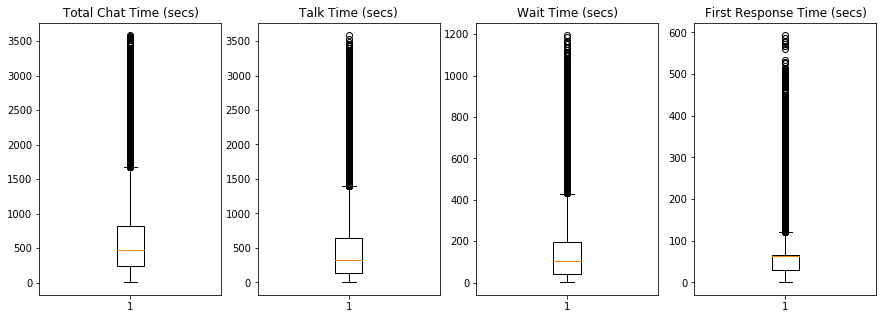

In [44]:
# 3G
# support chat boxplots
print('')
print('Support Chat Boxplots')

plt.figure(figsize = (15,5))

plt.subplot(1,4,1)
plt.boxplot(df_chat.chat_total)
plt.title("Total Chat Time (secs)")

plt.subplot(1,4,2)
plt.boxplot(df_chat.talk_time)
plt.title("Talk Time (secs)")

plt.subplot(1,4,3)
plt.boxplot(df_chat.wait_time)
plt.title("Wait Time (secs)")

plt.subplot(1,4,4)
plt.boxplot(df_chat.first_resp)
plt.title("First Response Time (secs)")

plt.show()

#### Observations  
- Outliers remain but appear consistent. Limits recommended by Matt appear to agree with the data.

Proctor Chat Boxplots


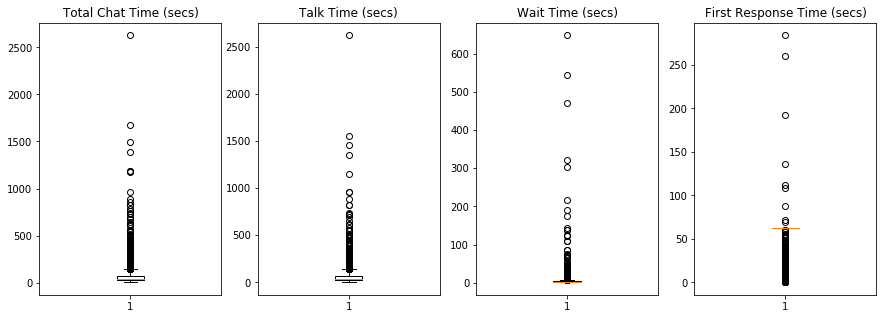

In [27]:
# 3H
# proctor chat boxplots
print('')
print('Proctor Chat Boxplots')

plt.figure(figsize = (15,5))

plt.subplot(1,4,1)
plt.boxplot(df_pop.chat_total)
plt.title("Total Chat Time (secs)")

plt.subplot(1,4,2)
plt.boxplot(df_pop.talk_time)
plt.title("Talk Time (secs)")

plt.subplot(1,4,3)
plt.boxplot(df_pop.wait_time)
plt.title("Wait Time (secs)")

plt.subplot(1,4,4)
plt.boxplot(df_pop.first_resp)
plt.title("First Response Time (secs)")

plt.show()

#### Observations  
- Outliers remain, and most appears sparse and solitary. Recommend shorter cutoff times for proctor chats.  
    - Total chat time: ~1000 secs (16.7 mins)  
    - Talk time: ~800 secs (13.3 mins)  
    - Wait time: ~100 secs (1.7 mins)  
    - First response time: ~75 secs (1.3 mins)

Support Chat Distributions (secs)


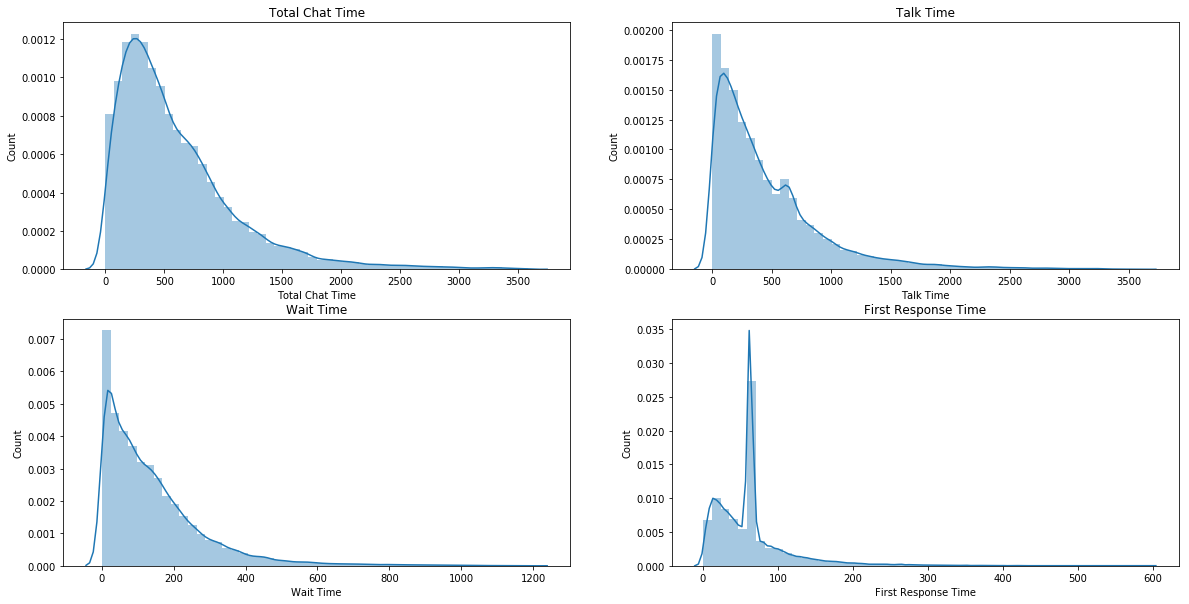

In [28]:
# 3I
# support chat distribution plots
print('')
print('Support Chat Distributions (secs)')

plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
sns.distplot(df_chat.chat_total)
plt.title('Total Chat Time')
plt.xlabel('Total Chat Time')
plt.ylabel('Count')

plt.subplot(2,2,2)
sns.distplot(df_chat.talk_time)
plt.title('Talk Time')
plt.xlabel('Talk Time')
plt.ylabel('Count')

plt.subplot(2,2,3)
sns.distplot(df_chat.wait_time)
plt.title('Wait Time')
plt.xlabel('Wait Time')
plt.ylabel('Count')

plt.subplot(2,2,4)
sns.distplot(df_chat.first_resp)
plt.title('First Response Time')
plt.xlabel('First Response Time')
plt.ylabel('Count')

plt.show()

#### Observations  
- Data still skewed right after dropping first round of outliers. Talk with Matt about potentially shortening the limits if necessary. 

Proctor Chat Distributions (secs)


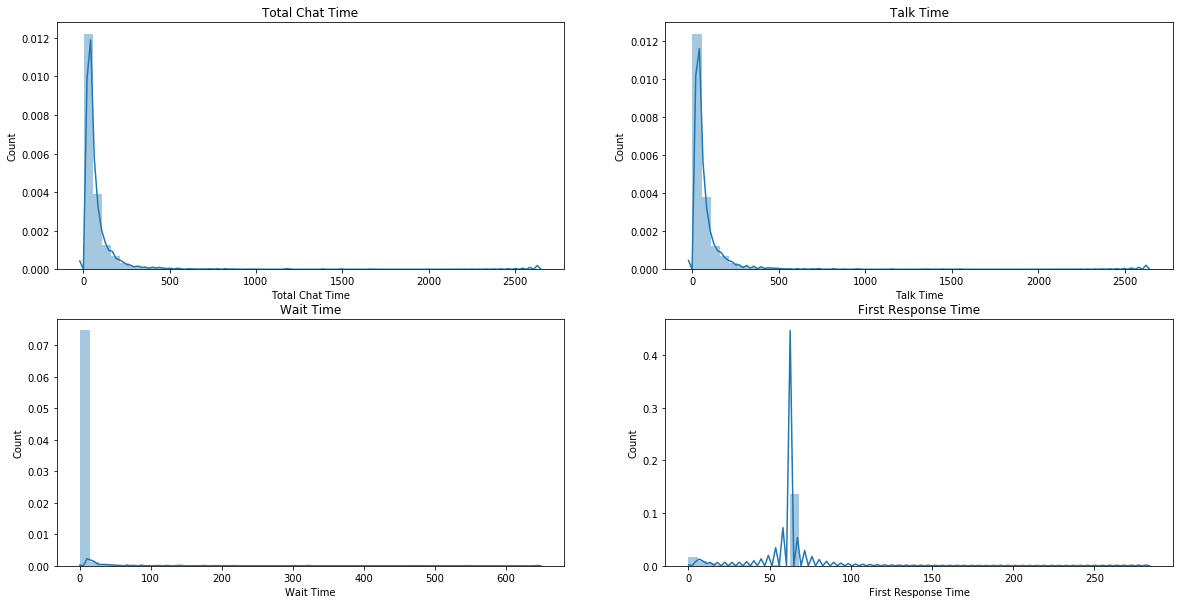

In [29]:
# 3J
# proctor chat distribution plots
print('')
print('Proctor Chat Distributions (secs)')

plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
sns.distplot(df_pop.chat_total)
plt.title('Total Chat Time')
plt.xlabel('Total Chat Time')
plt.ylabel('Count')

plt.subplot(2,2,2)
sns.distplot(df_pop.talk_time)
plt.title('Talk Time')
plt.xlabel('Talk Time')
plt.ylabel('Count')

plt.subplot(2,2,3)
sns.distplot(df_pop.wait_time)
plt.title('Wait Time')
plt.xlabel('Wait Time')
plt.ylabel('Count')

plt.subplot(2,2,4)
sns.distplot(df_pop.first_resp)
plt.title('First Response Time')
plt.xlabel('First Response Time')
plt.ylabel('Count')

plt.show()

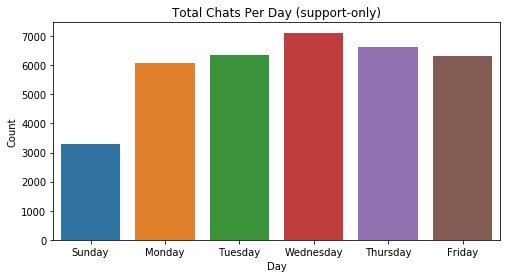

Total Chat count:  35819

Total Chats per day:

Wednesday    7122
Thursday     6642
Tuesday      6360
Friday       6313
Monday       6074
Sunday       3308
Name: day_name, dtype: int64


In [35]:
# 3K
# countplot of total chats per day (support-only)
plt.figure(figsize=(8,4))

sns.countplot(x=df_chat.day_name)
             
plt.title('Total Chats Per Day (support-only)')
plt.xlabel('Day')
plt.ylabel('Count')

plt.show()

# print total chat count
print('Total Chat count: ', df_chat.day_name.count())

print('')

# print totals
print('Total Chats per day:')
print('')
print(df_chat.day_name.value_counts())

#### Observations  
- After splitting support and proctor dataframes, a similar volume pattern remains for support chats. Wednesday was still the busiest day of the week, while all remaining weekdays follow not far behind. Sunday was again the slowest day by a significant amount.

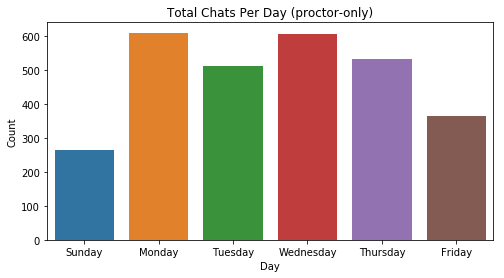

Total Chat count:  2894

Total Chats per day:

Monday       610
Wednesday    607
Thursday     534
Tuesday      513
Friday       366
Sunday       264
Name: day_name, dtype: int64


In [36]:
# 3L
# countplot of total chats per day (proctor-only)
plt.figure(figsize=(8,4))

sns.countplot(x=df_pop.day_name)
             
plt.title('Total Chats Per Day (proctor-only)')
plt.xlabel('Day')
plt.ylabel('Count')

plt.show()

# print total chat count
print('Total Chat count: ', df_pop.day_name.count())

print('')

# print totals
print('Total Chats per day:')
print('')
print(df_pop.day_name.value_counts())

#### Observations  
- Volume is fairly consistent Monday-Thursday.
- There appears to be no clear pattern other than Sunday reasonably being the slowest day of the week.


Correlation Heatmap


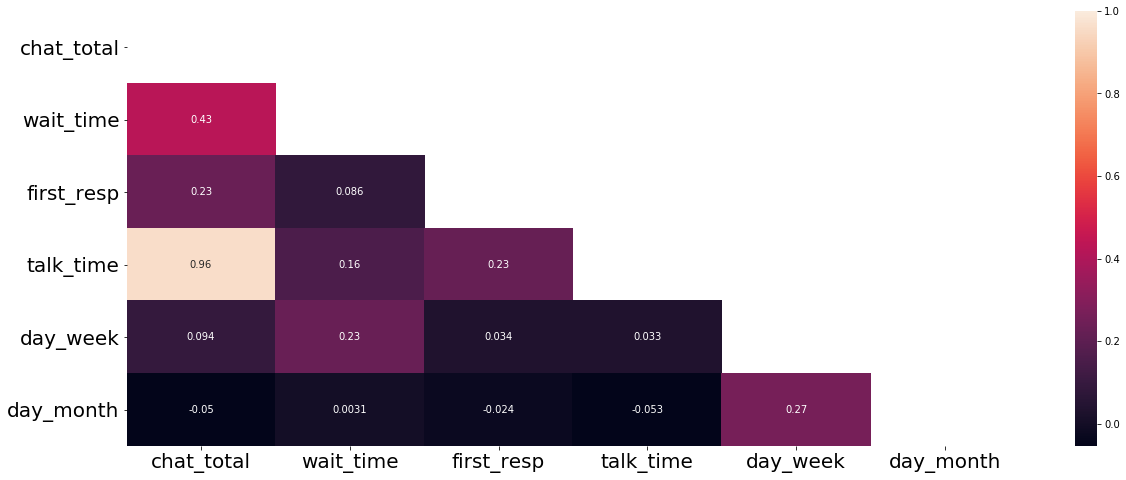

In [38]:
# 3M
# heatmap correlation matrix key numerical data (support-only)
print('')
print('Correlation Heatmap (support-only)')

corr = df_chat.corr()

# generate mask for upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(20,8))
sns.heatmap(corr, mask=mask, annot=True)

plt.tick_params(which='major', labelsize=20)
#plt.xticks(rotation=5)
plt.yticks(rotation=0)

plt.show()

#### Observations  
- Logical correlation between 'talk time' and 'total chat time'.  
- No other meaningful correlations present.


Correlation Heatmap (proctor-only)


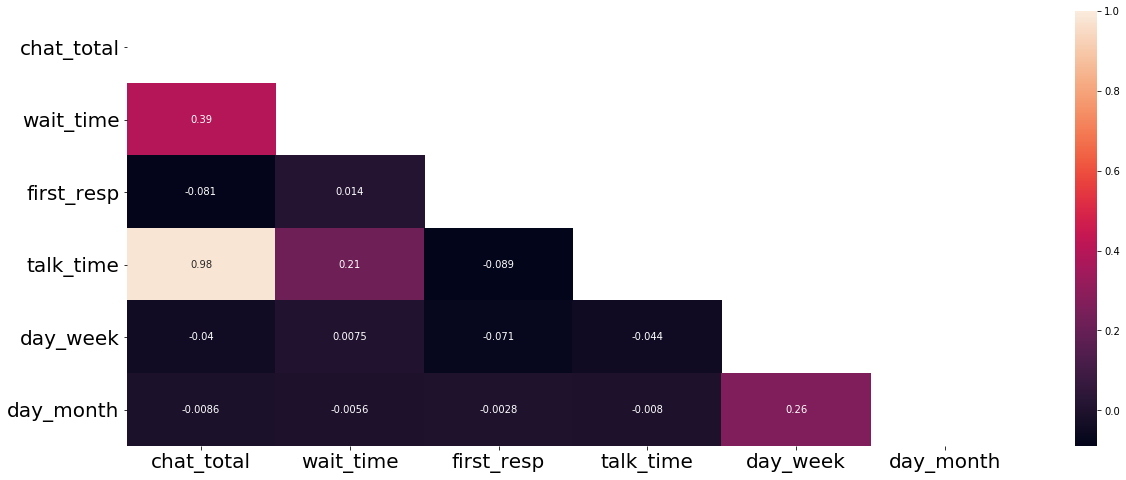

In [39]:
# 3N
# heatmap correlation matrix key numerical data (proctor-only)
print('')
print('Correlation Heatmap (proctor-only)')

corr = df_pop.corr()

# generate mask for upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(20,8))
sns.heatmap(corr, mask=mask, annot=True)

plt.tick_params(which='major', labelsize=20)
#plt.xticks(rotation=5)
plt.yticks(rotation=0)

plt.show()

#### Observations  
- Logical correlation between 'talk time' and 'total chat time'.  
- No other meaningful correlations present.

## 4. SUMMARY REPORT  
- __Basic initial dataset info__  
    - 39,026 peak instances (rows)  
    - 10 columns  
        - 5 categorical  
        - 5 numerical  


- __Significant missing data__  
    - Total chat duration: 72% missing  
        - Missing data was reverse-computed and filled by subtracting 'wait time' from 'total chat time'.  
    - First response time: 31% missing  
        - Missing data was filled using the average (mean) of the rest of the column.  
    - Saturday data completely missing
    
    
- __Significant outliers__  
    - Talk time: mean 33.4 mins  
        - Reasonable cutoff times were implemented per Matt's recommendation.  
        - Total chat time: 60 mins  
        - Talk time: 60 mins  
        - Wait time: 20 mins  
        - First response time: 10 mins
    
    
- __Comparison of averages (mean) before and after data cleaning__  
    - Before cleaning (support plus proctor)  
        - Total chat time: 9.8 mins    
        - Total talk time: 33.4 mins  
        - Wait time: 2.3 mins 
        - First response time: 1.1 mins  
    - After cleaning (support-only)  
        - Total chat time: 10.2 mins  
        - Talk time: 7.8 mins  
        - Wait time: 2.4 mins  
        - First response time: 1.1 mins  
        
        
- __Where did chats originate from this week?__  
    - Student: 76.4%  
    - Website: 8.7%  
    - Instructor: 7.6%  
    - Extension hall: 6%  
    
    
- Chat volume (support plus proctor) reasonably peaked on Wednesday, while other weekday volume was not far behind, with Friday being the slowest weekday by a small margin.  


- Proctor pop-in volume peaked on Monday with no clear pattern Monday-Friday.  


- Total chat time and talk time appear to be highly correlated (and is obvious using only common sense). A high talk time implies a high total chat time and vice versa.  
    - Support: 96% correlated  
    - Proctor: 98% correlated  
    
    
__Recommendations__  
1. Figure out if missing data was an anomoly or is something consistent from provider.  
2. Get more data. Much more could be gleaned from a monthly or even yearly dataset. We could look at very small timescales all the way up to semester or seasonal trends.  
3. Attempt to identify source of outliers. Why was there a chat that was days-long?
4. Further drilling down of chats per day into smaller timeblocks, possibly four hours (12-4a, 4-8a, etc.). This could potentially shed light on volume and staffing predictions.  
5. Comparison analysis of support chats vs. admin/instructor chats vs. proctor chats to aid in staffing predictions.  
6. Explore 